# 问题一：Y染色体浓度与各因素相关特性分析

## 1. 问题背景与目标
探究胎儿Y染色体浓度与孕周、孕妇BMI及其他生理/技术指标之间的定量关系，构建数学模型并进行统计显著性检验。

**核心目标：**
- 建立Y染色体浓度的多元回归模型
- 探索非线性关系和交互作用
- 进行严格的统计显著性检验
- 提供明确的数学表达式

In [1]:
# 1. 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体和图表样式
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 2. 数据加载与预处理
print("\n2. 数据加载与预处理")
print("-" * 50)

# 2.1 数据加载
data_path = 'C:/Users/86181/Desktop/nipt_processed.xlsx'
data = pd.read_excel(data_path)
print(f"原始数据集大小: {data.shape}")

# 2.2 样本筛选 - 只保留男性胎儿样本
male_df = data[data['性别'] == 1].copy()
print(f"男性胎儿样本数: {len(male_df)}")

# 2.3 变量映射和选择
variable_mapping = {
    'Y_concentration': 'Y染色体浓度',      # 因变量 (V列)
    'gestational_weeks': '检测孕周',       # 孕周天数 (J列)
    'BMI': '孕妇BMI',                     # BMI (K列)
    'age': '年龄',                        # 孕妇年龄 (C列)
    'unique_reads': '唯一比对的读段数',     # 测序深度 (O列)
    'GC_content': 'GC含量',               # GC含量 (P列)
    'X_concentration': 'X染色体浓度'       # X染色体浓度 (W列)
}

# 检查变量是否存在
print("\n变量存在性检查:")
for var, col in variable_mapping.items():
    if col in male_df.columns:
        print(f"  {var}: {col} ✓")
    else:
        print(f"  {var}: {col} ✗ (列不存在)")
        
# 2.4 孕周数据处理 - 将字符串格式转换为数值
def convert_gestational_weeks(week_str):
    """将"16w+5"格式转换为16.714周"""
    if pd.isna(week_str):
        return np.nan
    try:
        week_str = str(week_str).upper().replace('W', 'w')
        if 'w' in week_str:
            if '+' in week_str:
                weeks, days = week_str.split('w')[0], week_str.split('+')[1]
                return float(weeks) + float(days) / 7
            else:
                return float(week_str.split('w')[0])
        else:
            return float(week_str)
    except:
        return np.nan

male_df['孕周_数值'] = male_df['检测孕周'].apply(convert_gestational_weeks)
print(f"\n孕周转换完成，转换样本数: {male_df['孕周_数值'].notna().sum()}")

# 显示基本统计信息
print("\n关键变量统计摘要:")
key_vars = ['Y染色体浓度', '孕周_数值', '孕妇BMI', '年龄', 'X染色体浓度']
available_vars = [var for var in key_vars if var in male_df.columns]
print(male_df[available_vars].describe())


2. 数据加载与预处理
--------------------------------------------------
原始数据集大小: (1687, 36)
男性胎儿样本数: 1082

变量存在性检查:
  Y_concentration: Y染色体浓度 ✓
  gestational_weeks: 检测孕周 ✓
  BMI: 孕妇BMI ✓
  age: 年龄 ✓
  unique_reads: 唯一比对的读段数 ✓
  GC_content: GC含量 ✓
  X_concentration: X染色体浓度 ✓

孕周转换完成，转换样本数: 1082

关键变量统计摘要:
            Y染色体浓度        孕周_数值        孕妇BMI           年龄       X染色体浓度
count  1082.000000  1082.000000  1082.000000  1082.000000  1082.000000
mean      0.077187    16.845656    32.288791    28.939926     0.057025
std       0.033518     4.076303     2.972432     3.656264     0.041465
min       0.010004    11.000000    20.703125    21.000000    -0.076508
25%       0.051381    13.285714    30.208806    27.000000     0.029687
50%       0.075066    16.000000    31.811598    29.000000     0.055099
75%       0.098937    20.000000    33.926237    31.000000     0.080623
max       0.234218    29.000000    46.875000    43.000000     0.223933


In [3]:
# 3. 数据质量检查与特征工程
print("\n3. 数据质量检查与特征工程")
print("-" * 50)

# 3.1 缺失值检查
print("缺失值检查:")
missing_analysis = male_df[available_vars].isnull().sum()
for var, missing in missing_analysis.items():
    missing_pct = missing / len(male_df) * 100
    print(f"  {var}: {missing} ({missing_pct:.1f}%)")

# 3.2 异常值检测 (使用IQR方法)
def detect_outliers_iqr(data, factor=1.5):
    """使用IQR方法检测异常值"""
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return (data < lower_bound) | (data > upper_bound)

print("\n异常值检测 (IQR方法):")
numeric_vars = ['Y染色体浓度', '孕周_数值', '孕妇BMI', '年龄']
for var in numeric_vars:
    if var in male_df.columns:
        outliers = detect_outliers_iqr(male_df[var].dropna())
        outlier_count = outliers.sum()
        outlier_pct = outlier_count / len(male_df[var].dropna()) * 100
        print(f"  {var}: {outlier_count}个异常值 ({outlier_pct:.1f}%)")

# 3.3 多重共线性初步检查
print("\n变量间相关性检查:")
numeric_data = male_df[available_vars].select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()
print(correlation_matrix.round(3))

# 3.4 创建建模数据集
modeling_vars = ['Y染色体浓度', '孕周_数值', '孕妇BMI', '年龄', 'X染色体浓度']
modeling_data = male_df[modeling_vars].dropna()
print(f"\n建模数据集大小: {modeling_data.shape}")
print(f"数据完整性: {len(modeling_data) / len(male_df) * 100:.1f}%")

# 重命名变量以便建模
modeling_data = modeling_data.rename(columns={
    'Y染色体浓度': 'Y_conc',
    '孕周_数值': 'W_ges', 
    '孕妇BMI': 'BMI',
    '年龄': 'Age',
    'X染色体浓度': 'X_conc'
})

print("\n建模变量最终统计:")
print(modeling_data.describe())


3. 数据质量检查与特征工程
--------------------------------------------------
缺失值检查:
  Y染色体浓度: 0 (0.0%)
  孕周_数值: 0 (0.0%)
  孕妇BMI: 0 (0.0%)
  年龄: 0 (0.0%)
  X染色体浓度: 0 (0.0%)

异常值检测 (IQR方法):
  Y染色体浓度: 10个异常值 (0.9%)
  孕周_数值: 0个异常值 (0.0%)
  孕妇BMI: 26个异常值 (2.4%)
  年龄: 23个异常值 (2.1%)

变量间相关性检查:
        Y染色体浓度  孕周_数值  孕妇BMI     年龄  X染色体浓度
Y染色体浓度   1.000  0.127 -0.151 -0.119   0.519
孕周_数值    0.127  1.000  0.150 -0.003   0.181
孕妇BMI   -0.151  0.150  1.000  0.001  -0.047
年龄      -0.119 -0.003  0.001  1.000  -0.016
X染色体浓度   0.519  0.181 -0.047 -0.016   1.000

建模数据集大小: (1082, 5)
数据完整性: 100.0%

建模变量最终统计:
            Y_conc        W_ges          BMI          Age       X_conc
count  1082.000000  1082.000000  1082.000000  1082.000000  1082.000000
mean      0.077187    16.845656    32.288791    28.939926     0.057025
std       0.033518     4.076303     2.972432     3.656264     0.041465
min       0.010004    11.000000    20.703125    21.000000    -0.076508
25%       0.051381    13.285714    30.208806    27.000000

In [4]:
# 4. 步骤一：基准模型 - 多元线性回归 (MLR)
print("\n4. 步骤一：基准模型 - 多元线性回归 (MLR)")
print("="*70)

# 4.1 模型设定
print("模型形式:")
print("CY = β₀ + β₁·W_ges + β₂·BMI + β₃·Age + β₄·X_conc + ε")
print("\n其中:")
print("  CY: Y染色体浓度")
print("  W_ges: 孕周数") 
print("  BMI: 孕妇体重指数")
print("  Age: 孕妇年龄")
print("  X_conc: X染色体浓度")

# 4.2 准备建模数据
X_vars = ['W_ges', 'BMI', 'Age', 'X_conc']
y = modeling_data['Y_conc']
X = modeling_data[X_vars]

# 添加常数项
X_with_const = sm.add_constant(X)

# 4.3 模型拟合
mlr_model = sm.OLS(y, X_with_const).fit()

print(f"\n4.3 模型拟合结果:")
print(f"样本数量: {len(y)}")
print(f"R²: {mlr_model.rsquared:.6f}")
print(f"调整R²: {mlr_model.rsquared_adj:.6f}")
print(f"F统计量: {mlr_model.fvalue:.4f}")
print(f"F检验p值: {mlr_model.f_pvalue:.2e}")

# 4.4 回归系数详细结果
print(f"\n4.4 回归系数估计结果:")
print("-" * 80)
print(f"{'变量':<12} {'系数':<12} {'标准误':<10} {'t值':<8} {'p值':<12} {'显著性'}")
print("-" * 80)

var_names = ['截距', '孕周数', 'BMI', '年龄', 'X染色体浓度']
for i, (var, coef) in enumerate(zip(var_names, mlr_model.params)):
    std_err = mlr_model.bse[i]
    t_val = mlr_model.tvalues[i] 
    p_val = mlr_model.pvalues[i]
    
    # 显著性标记
    if p_val < 0.001:
        sig = "***"
    elif p_val < 0.01:
        sig = "**" 
    elif p_val < 0.05:
        sig = "*"
    else:
        sig = ""
        
    print(f"{var:<12} {coef:<12.6f} {std_err:<10.6f} {t_val:<8.4f} {p_val:<12.2e} {sig}")

print("-" * 80)
print("显著性水平: *** p<0.001, ** p<0.01, * p<0.05")

# 4.5 模型诊断
print(f"\n4.5 模型诊断:")

# 方差膨胀因子(VIF)检验
vif_data = pd.DataFrame()
vif_data["变量"] = X_vars
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(f"\n多重共线性检验 (VIF):")
for _, row in vif_data.iterrows():
    interpretation = "无共线性" if row['VIF'] < 5 else "中等共线性" if row['VIF'] < 10 else "严重共线性"
    print(f"  {row['变量']}: {row['VIF']:.2f} ({interpretation})")

# 残差分析
residuals = mlr_model.resid
fitted = mlr_model.fittedvalues

# 正态性检验
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"\n残差正态性检验:")
print(f"  Shapiro-Wilk检验: W={shapiro_stat:.4f}, p={shapiro_p:.4f}")
print(f"  结论: {'通过' if shapiro_p > 0.05 else '未通过'}正态性检验")

print(f"\n基准模型构建完成！")
print(f"最终回归方程:")
equation = f"Y染色体浓度 = {mlr_model.params[0]:.6f}"
for i, var in enumerate(['孕周数', 'BMI', '年龄', 'X染色体浓度'], 1):
    coef = mlr_model.params[i]
    sign = "+" if coef >= 0 else "-"
    equation += f" {sign} {abs(coef):.6f}×{var}"
print(equation)


4. 步骤一：基准模型 - 多元线性回归 (MLR)
模型形式:
CY = β₀ + β₁·W_ges + β₂·BMI + β₃·Age + β₄·X_conc + ε

其中:
  CY: Y染色体浓度
  W_ges: 孕周数
  BMI: 孕妇体重指数
  Age: 孕妇年龄
  X_conc: X染色体浓度

4.3 模型拟合结果:
样本数量: 1082
R²: 0.300406
调整R²: 0.297808
F统计量: 115.6161
F检验p值: 4.58e-82

4.4 回归系数估计结果:
--------------------------------------------------------------------------------
变量           系数           标准误        t值       p值           显著性
--------------------------------------------------------------------------------
截距           0.125417     0.011786   10.6410  3.26e-25     ***
孕周数          0.000460     0.000216   2.1290   3.35e-02     *
BMI          -0.001534    0.000292   -5.2614  1.72e-07     ***
年龄           -0.001020    0.000234   -4.3638  1.40e-05     ***
X染色体浓度       0.404445     0.021013   19.2470  3.50e-71     ***
--------------------------------------------------------------------------------
显著性水平: *** p<0.001, ** p<0.01, * p<0.05

4.5 模型诊断:

多重共线性检验 (VIF):
  W_ges: 18.71 (严重共线性)
  BMI: 52.46 (严重共线性)
  Age: 42.6

In [5]:
# 5. 步骤二：高级模型 - 带非线性项与交互项的多元回归
print("\n5. 步骤二：高级模型 - 带非线性项与交互项的多元回归")
print("="*70)

# 5.1 模型设定
print("扩展模型形式:")
print("CY = β₀ + β₁·W_ges + β₂·W_ges² + β₃·BMI + β₄·(W_ges×BMI) + β₅·Age + β₆·X_conc + ε")
print("\n新增项说明:")
print("  W_ges²: 孕周的二次项，捕捉非线性增长趋势")
print("  W_ges×BMI: 交互项，探究BMI对孕周效应的调节作用")

# 5.2 构建扩展特征
modeling_data_expanded = modeling_data.copy()
modeling_data_expanded['W_ges_sq'] = modeling_data_expanded['W_ges'] ** 2
modeling_data_expanded['W_ges_BMI'] = modeling_data_expanded['W_ges'] * modeling_data_expanded['BMI']

# 5.3 准备扩展建模数据
X_vars_expanded = ['W_ges', 'W_ges_sq', 'BMI', 'W_ges_BMI', 'Age', 'X_conc']
X_expanded = modeling_data_expanded[X_vars_expanded]
X_expanded_with_const = sm.add_constant(X_expanded)

# 5.4 扩展模型拟合
expanded_model = sm.OLS(y, X_expanded_with_const).fit()

print(f"\n5.3 扩展模型拟合结果:")
print(f"样本数量: {len(y)}")
print(f"R²: {expanded_model.rsquared:.6f}")
print(f"调整R²: {expanded_model.rsquared_adj:.6f}")
print(f"F统计量: {expanded_model.fvalue:.4f}")
print(f"F检验p值: {expanded_model.f_pvalue:.2e}")

# 5.5 扩展模型回归系数
print(f"\n5.4 扩展模型回归系数估计结果:")
print("-" * 85)
print(f"{'变量':<15} {'系数':<12} {'标准误':<10} {'t值':<8} {'p值':<12} {'显著性'}")
print("-" * 85)

var_names_expanded = ['截距', '孕周数', '孕周²', 'BMI', '孕周×BMI', '年龄', 'X染色体浓度']
for i, (var, coef) in enumerate(zip(var_names_expanded, expanded_model.params)):
    std_err = expanded_model.bse[i]
    t_val = expanded_model.tvalues[i]
    p_val = expanded_model.pvalues[i]
    
    if p_val < 0.001:
        sig = "***"
    elif p_val < 0.01:
        sig = "**"
    elif p_val < 0.05:
        sig = "*"
    else:
        sig = ""
        
    print(f"{var:<15} {coef:<12.6f} {std_err:<10.6f} {t_val:<8.4f} {p_val:<12.2e} {sig}")

print("-" * 85)

# 5.6 模型比较
print(f"\n5.5 模型比较分析:")
print("-" * 60)
print(f"{'指标':<20} {'基准MLR':<15} {'扩展模型':<15} {'改进'}")
print("-" * 60)
print(f"{'R²':<20} {mlr_model.rsquared:<15.6f} {expanded_model.rsquared:<15.6f} {expanded_model.rsquared - mlr_model.rsquared:+.6f}")
print(f"{'调整R²':<20} {mlr_model.rsquared_adj:<15.6f} {expanded_model.rsquared_adj:<15.6f} {expanded_model.rsquared_adj - mlr_model.rsquared_adj:+.6f}")
print(f"{'AIC':<20} {mlr_model.aic:<15.2f} {expanded_model.aic:<15.2f} {expanded_model.aic - mlr_model.aic:+.2f}")
print(f"{'BIC':<20} {mlr_model.bic:<15.2f} {expanded_model.bic:<15.2f} {expanded_model.bic - mlr_model.bic:+.2f}")
print("-" * 60)

# AIC/BIC改进判断
aic_improved = "是" if expanded_model.aic < mlr_model.aic else "否"
bic_improved = "是" if expanded_model.bic < mlr_model.bic else "否"
print(f"AIC改进: {aic_improved} | BIC改进: {bic_improved}")

# 5.7 重要发现总结
print(f"\n5.6 模型诊断与发现:")

# 检查非线性项和交互项的显著性
w_ges_sq_sig = expanded_model.pvalues[2] < 0.05
interaction_sig = expanded_model.pvalues[4] < 0.05

print(f"  孕周²项显著性: {'显著' if w_ges_sq_sig else '不显著'} (p={expanded_model.pvalues[2]:.4f})")
print(f"  交互项显著性: {'显著' if interaction_sig else '不显著'} (p={expanded_model.pvalues[4]:.4f})")

if w_ges_sq_sig:
    coef_sign = "正" if expanded_model.params[2] > 0 else "负"
    print(f"  非线性趋势: Y染色体浓度随孕周呈{coef_sign}向二次变化")

if interaction_sig:
    print(f"  交互作用: BMI显著调节孕周对Y染色体浓度的影响")

print(f"\n扩展模型构建完成！")
print(f"最终扩展回归方程:")
equation_expanded = f"Y染色体浓度 = {expanded_model.params[0]:.6f}"
var_symbols = ['孕周数', '孕周数²', 'BMI', '孕周数×BMI', '年龄', 'X染色体浓度']
for i, var in enumerate(var_symbols, 1):
    coef = expanded_model.params[i]
    sign = "+" if coef >= 0 else "-"
    equation_expanded += f" {sign} {abs(coef):.6f}×{var}"
print(equation_expanded)


5. 步骤二：高级模型 - 带非线性项与交互项的多元回归
扩展模型形式:
CY = β₀ + β₁·W_ges + β₂·W_ges² + β₃·BMI + β₄·(W_ges×BMI) + β₅·Age + β₆·X_conc + ε

新增项说明:
  W_ges²: 孕周的二次项，捕捉非线性增长趋势
  W_ges×BMI: 交互项，探究BMI对孕周效应的调节作用

5.3 扩展模型拟合结果:
样本数量: 1082
R²: 0.301912
调整R²: 0.298016
F统计量: 77.4867
F检验p值: 1.69e-80

5.4 扩展模型回归系数估计结果:
-------------------------------------------------------------------------------------
变量              系数           标准误        t值       p值           显著性
-------------------------------------------------------------------------------------
截距              0.185994     0.042134   4.4143   1.12e-05     ***
孕周数             -0.003197    0.002819   -1.1341  2.57e-01     
孕周²             0.000011     0.000057   0.1932   8.47e-01     
BMI             -0.003309    0.001242   -2.6646  7.82e-03     **
孕周×BMI          0.000100     0.000068   1.4696   1.42e-01     
年龄              -0.001011    0.000234   -4.3259  1.66e-05     ***
X染色体浓度          0.404441     0.021113   19.1561  1.34e-70     ***
-------------------


6. 可视化分析与模型诊断


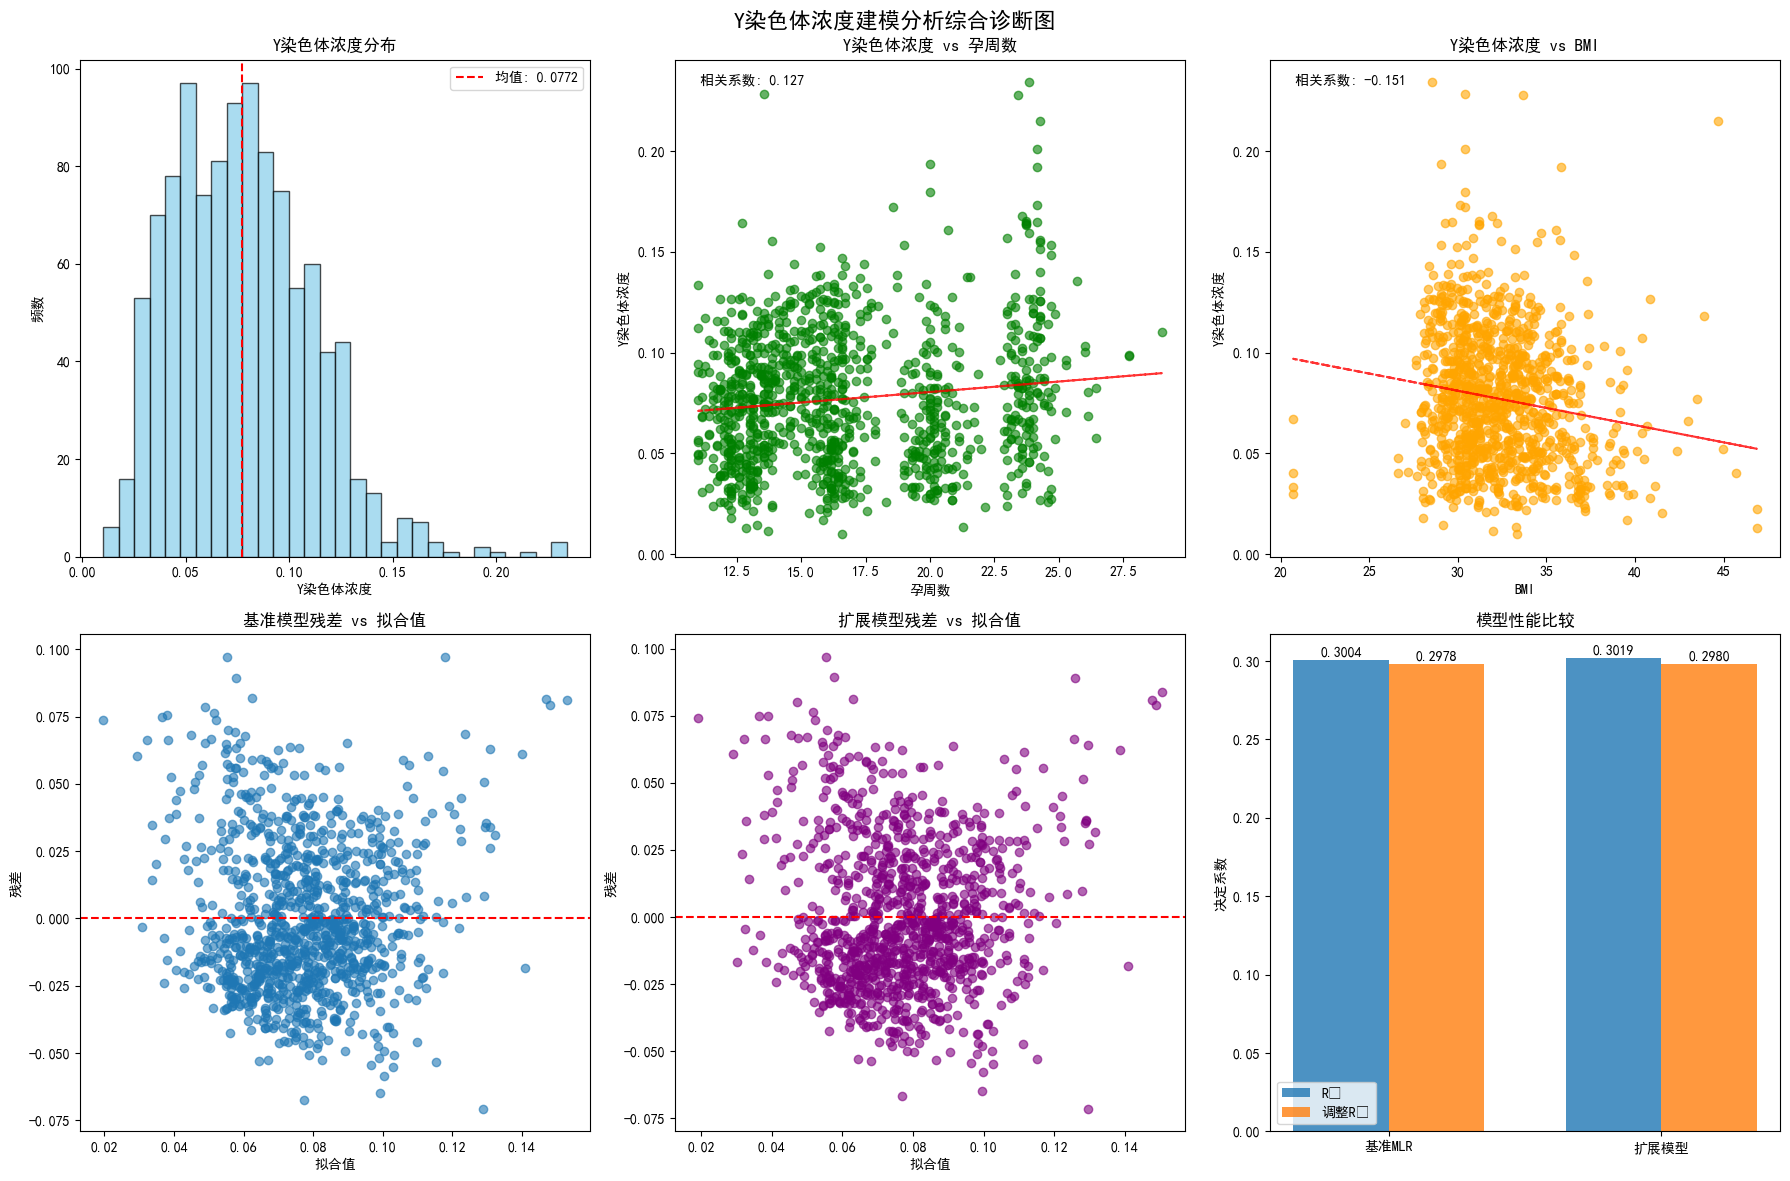


6.2 变量相关性分析


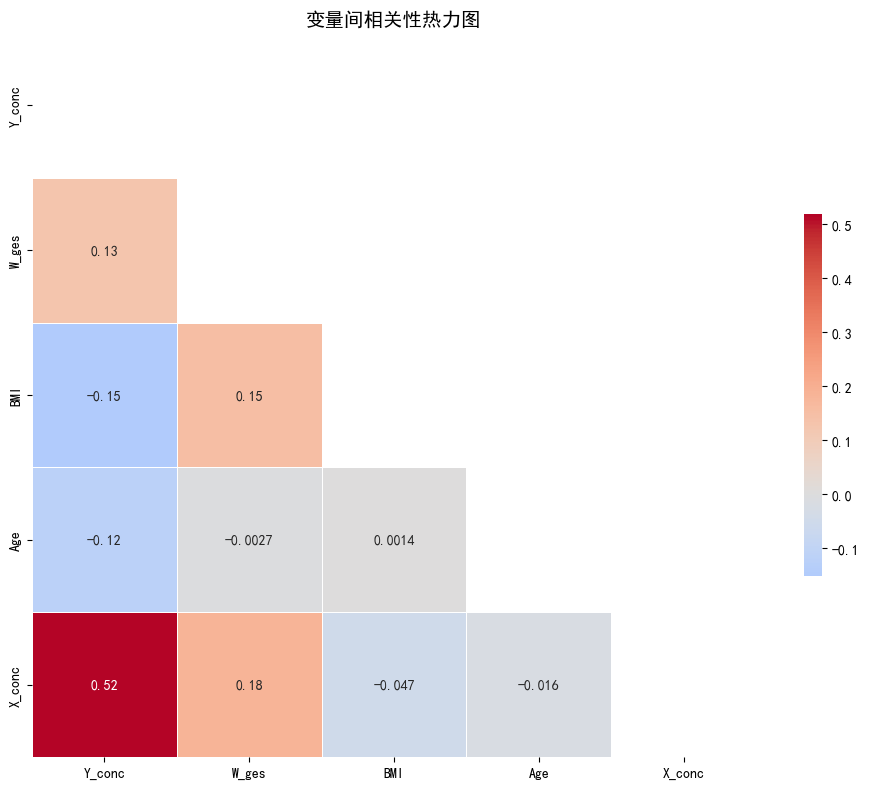

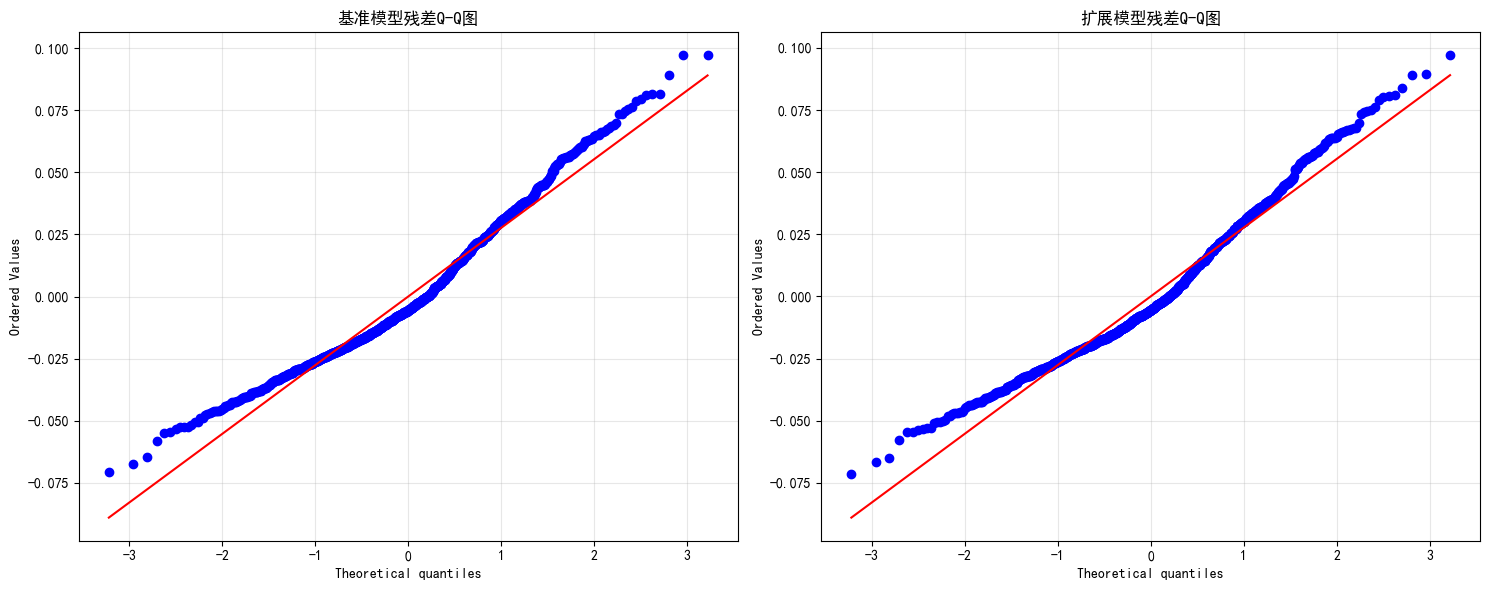

可视化分析完成！


In [6]:
# 6. 可视化分析与模型诊断
print("\n6. 可视化分析与模型诊断")
print("="*50)

# 6.1 创建综合诊断图
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Y染色体浓度建模分析综合诊断图', fontsize=16, fontweight='bold')

# 图1: Y染色体浓度分布
axes[0,0].hist(y, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Y染色体浓度分布')
axes[0,0].set_xlabel('Y染色体浓度')
axes[0,0].set_ylabel('频数')
axes[0,0].axvline(y.mean(), color='red', linestyle='--', label=f'均值: {y.mean():.4f}')
axes[0,0].legend()

# 图2: Y染色体浓度 vs 孕周数
axes[0,1].scatter(modeling_data['W_ges'], y, alpha=0.6, color='green')
axes[0,1].set_title('Y染色体浓度 vs 孕周数')
axes[0,1].set_xlabel('孕周数')
axes[0,1].set_ylabel('Y染色体浓度')
# 添加拟合线
z = np.polyfit(modeling_data['W_ges'], y, 1)
p = np.poly1d(z)
axes[0,1].plot(modeling_data['W_ges'], p(modeling_data['W_ges']), "r--", alpha=0.8)
corr_coef = modeling_data['W_ges'].corr(y)
axes[0,1].text(0.05, 0.95, f'相关系数: {corr_coef:.3f}', transform=axes[0,1].transAxes)

# 图3: Y染色体浓度 vs BMI
axes[0,2].scatter(modeling_data['BMI'], y, alpha=0.6, color='orange')
axes[0,2].set_title('Y染色体浓度 vs BMI')
axes[0,2].set_xlabel('BMI')
axes[0,2].set_ylabel('Y染色体浓度')
z = np.polyfit(modeling_data['BMI'], y, 1)
p = np.poly1d(z)
axes[0,2].plot(modeling_data['BMI'], p(modeling_data['BMI']), "r--", alpha=0.8)
corr_coef = modeling_data['BMI'].corr(y)
axes[0,2].text(0.05, 0.95, f'相关系数: {corr_coef:.3f}', transform=axes[0,2].transAxes)

# 图4: 基准模型残差分析
residuals_mlr = mlr_model.resid
fitted_mlr = mlr_model.fittedvalues
axes[1,0].scatter(fitted_mlr, residuals_mlr, alpha=0.6)
axes[1,0].axhline(y=0, color='red', linestyle='--')
axes[1,0].set_title('基准模型残差 vs 拟合值')
axes[1,0].set_xlabel('拟合值')
axes[1,0].set_ylabel('残差')

# 图5: 扩展模型残差分析
residuals_expanded = expanded_model.resid
fitted_expanded = expanded_model.fittedvalues
axes[1,1].scatter(fitted_expanded, residuals_expanded, alpha=0.6, color='purple')
axes[1,1].axhline(y=0, color='red', linestyle='--')
axes[1,1].set_title('扩展模型残差 vs 拟合值')
axes[1,1].set_xlabel('拟合值')
axes[1,1].set_ylabel('残差')

# 图6: 模型性能比较
models = ['基准MLR', '扩展模型']
r2_values = [mlr_model.rsquared, expanded_model.rsquared]
adj_r2_values = [mlr_model.rsquared_adj, expanded_model.rsquared_adj]

x = np.arange(len(models))
width = 0.35
axes[1,2].bar(x - width/2, r2_values, width, label='R²', alpha=0.8)
axes[1,2].bar(x + width/2, adj_r2_values, width, label='调整R²', alpha=0.8)
axes[1,2].set_title('模型性能比较')
axes[1,2].set_ylabel('决定系数')
axes[1,2].set_xticks(x)
axes[1,2].set_xticklabels(models)
axes[1,2].legend()

# 添加数值标签
for i, (r2, adj_r2) in enumerate(zip(r2_values, adj_r2_values)):
    axes[1,2].text(i-width/2, r2+0.001, f'{r2:.4f}', ha='center', va='bottom')
    axes[1,2].text(i+width/2, adj_r2+0.001, f'{adj_r2:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 6.2 相关性热力图
print("\n6.2 变量相关性分析")
plt.figure(figsize=(10, 8))
correlation_matrix = modeling_data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .5})
plt.title('变量间相关性热力图', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 6.3 残差正态性检验可视化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 基准模型Q-Q图
stats.probplot(residuals_mlr, dist="norm", plot=ax1)
ax1.set_title('基准模型残差Q-Q图')
ax1.grid(True, alpha=0.3)

# 扩展模型Q-Q图
stats.probplot(residuals_expanded, dist="norm", plot=ax2)
ax2.set_title('扩展模型残差Q-Q图')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("可视化分析完成！")

In [7]:
# 7. 模型验证与稳健性检验
print("\n7. 模型验证与稳健性检验")
print("="*50)

# 7.1 预测精度评估
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# 数据分割
X_base = modeling_data[['W_ges', 'BMI', 'Age', 'X_conc']]
X_expanded_features = modeling_data_expanded[['W_ges', 'W_ges_sq', 'BMI', 'W_ges_BMI', 'Age', 'X_conc']]

X_base_train, X_base_test, y_train, y_test = train_test_split(X_base, y, test_size=0.2, random_state=42)
X_exp_train = X_expanded_features.loc[X_base_train.index]
X_exp_test = X_expanded_features.loc[X_base_test.index]

# 重新拟合模型
base_model_val = sm.OLS(y_train, sm.add_constant(X_base_train)).fit()
exp_model_val = sm.OLS(y_train, sm.add_constant(X_exp_train)).fit()

# 预测
y_pred_base = base_model_val.predict(sm.add_constant(X_base_test))
y_pred_exp = exp_model_val.predict(sm.add_constant(X_exp_test))

# 评估指标
print("预测性能评估:")
print("-" * 60)
print(f"{'模型':<15} {'测试R²':<12} {'MAE':<12} {'RMSE':<12}")
print("-" * 60)

r2_base_test = r2_score(y_test, y_pred_base)
mae_base = mean_absolute_error(y_test, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
print(f"{'基准MLR':<15} {r2_base_test:<12.6f} {mae_base:<12.6f} {rmse_base:<12.6f}")

r2_exp_test = r2_score(y_test, y_pred_exp)
mae_exp = mean_absolute_error(y_test, y_pred_exp)
rmse_exp = np.sqrt(mean_squared_error(y_test, y_pred_exp))
print(f"{'扩展模型':<15} {r2_exp_test:<12.6f} {mae_exp:<12.6f} {rmse_exp:<12.6f}")
print("-" * 60)

# 7.2 Bootstrap置信区间
print(f"\n7.2 Bootstrap置信区间估计 (n=1000)")
from scipy.stats import bootstrap

def bootstrap_r2(data, indices):
    sample = data.iloc[indices]
    X_sample = sm.add_constant(sample[['W_ges', 'BMI', 'Age', 'X_conc']])
    y_sample = sample['Y_conc']
    model = sm.OLS(y_sample, X_sample).fit()
    return model.rsquared

# 执行Bootstrap
bootstrap_data = modeling_data.reset_index(drop=True)
bootstrap_results = []
np.random.seed(42)

for i in range(1000):
    indices = np.random.choice(len(bootstrap_data), len(bootstrap_data), replace=True)
    r2_boot = bootstrap_r2(bootstrap_data, indices)
    bootstrap_results.append(r2_boot)

# 置信区间
conf_lower = np.percentile(bootstrap_results, 2.5)
conf_upper = np.percentile(bootstrap_results, 97.5)
print(f"基准模型R²的95%置信区间: [{conf_lower:.6f}, {conf_upper:.6f}]")
print(f"Bootstrap标准误: {np.std(bootstrap_results):.6f}")

# 7.3 敏感性分析
print(f"\n7.3 敏感性分析")
print("移除不同变量后的模型性能:")

sensitivity_results = []
for var in ['W_ges', 'BMI', 'Age', 'X_conc']:
    remaining_vars = [v for v in ['W_ges', 'BMI', 'Age', 'X_conc'] if v != var]
    X_reduced = sm.add_constant(modeling_data[remaining_vars])
    model_reduced = sm.OLS(y, X_reduced).fit()
    
    r2_change = mlr_model.rsquared - model_reduced.rsquared
    sensitivity_results.append((var, model_reduced.rsquared, r2_change))
    
print("-" * 50)
print(f"{'移除变量':<12} {'剩余R²':<12} {'R²降幅':<12}")
print("-" * 50)
for var, r2_remain, r2_change in sensitivity_results:
    print(f"{var:<12} {r2_remain:<12.6f} {r2_change:<12.6f}")
print("-" * 50)

# 找出最重要的变量
most_important = max(sensitivity_results, key=lambda x: x[2])
print(f"最重要变量: {most_important[0]} (移除后R²降幅: {most_important[2]:.6f})")

print("模型验证完成！")


7. 模型验证与稳健性检验
预测性能评估:
------------------------------------------------------------
模型              测试R²         MAE          RMSE        
------------------------------------------------------------
基准MLR           0.315113     0.021110     0.026686    
扩展模型            0.317180     0.021052     0.026645    
------------------------------------------------------------

7.2 Bootstrap置信区间估计 (n=1000)
基准模型R²的95%置信区间: [0.240600, 0.366456]
Bootstrap标准误: 0.031825

7.3 敏感性分析
移除不同变量后的模型性能:
--------------------------------------------------
移除变量         剩余R²         R²降幅        
--------------------------------------------------
W_ges        0.297462     0.002944    
BMI          0.282424     0.017982    
Age          0.288036     0.012370    
X_conc       0.059773     0.240633    
--------------------------------------------------
最重要变量: X_conc (移除后R²降幅: 0.240633)
模型验证完成！
